In [2]:
# imports and installs

import sys, os
old_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")
!{sys.executable} -m pip install -q awswrangler pandas;
!{sys.executable} -m pip install -qU awscli boto3 "sagemaker==2.84.0";
sys.stdout = old_stdout

In [3]:
# imports and installs

from sagemaker import Session

session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-sagemaker-clarify"
region = session.boto_region_name
# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import os
import boto3

role = get_execution_role()
s3_client = boto3.client("s3")

In [6]:
# put data into dataframe

import pandas as pd

df = pd.read_csv("agaricus-lepiota.data")
df.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [10]:
# separate into testing and training

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, train_size=0.7)

In [41]:
# preprocessing

from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


train = pd.concat([train["p"], train.drop(["p"], axis=1)], axis=1)
train, _ = number_encode_features(train)
train.to_csv("train_data.csv", index=False, header=False)

test, _ = number_encode_features(test)
test_features = test.drop(["p"], axis=1)
test_target = test["p"]
test_features.to_csv("test_features.csv", index=False, header=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [42]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))

In [43]:
# training

from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.2-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)


2022-04-20 16:55:07 Starting - Starting the training job.....
2022-04-20 16:55:37 Starting - Preparing the instances for training..............
2022-04-20 16:56:52 Downloading - Downloading input data....
2022-04-20 16:57:18 Training - Downloading the training image..........
2022-04-20 16:58:13 Training - Training image download completed. Training in progress....
2022-04-20 16:58:29 Uploading - Uploading generated training model
2022-04-20 16:58:35 Completed - Training job completed


In [44]:
model_name = "DEMO-clarify-model"
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

Using already existing model: DEMO-clarify-model


'DEMO-clarify-model'

In [45]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

In [46]:
# get bias report

bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="p",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

DataConfig will be deprecated on 15 Mar 2022.s3_data_distribution_type parameter will no longer be supported. Everything else will remain as is in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [47]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

In [48]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)


In [51]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="x", facet_values_or_threshold=[0], group_name="s"
)

In [52]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2022-04-20-17-12-02-472
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...........

In [53]:
bias_report_output_path

's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-bias'

In [61]:
shap_config = clarify.SHAPConfig(
    baseline=[test_features.iloc[0].values.tolist()],
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="p",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

DataConfig will be deprecated on 15 Mar 2022.s3_data_distribution_type parameter will no longer be supported. Everything else will remain as is in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [62]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2022-04-20-18-59-46-883
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMo

In [63]:
explainability_output_path

's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-explainability'

Example number: 111 
with model prediction: True

Feature values -- Label p       1
x       5
s       2
n       3
t       1
p.1     2
f       1
c       0
n.1     0
k      10
e       1
e.1     1
s.1     0
s.2     0
w       7
w.1     7
p.2     0
w.2     2
o       1
p.3     4
k.1     1
s.3     3
u       5
Name: 5455, dtype: int64


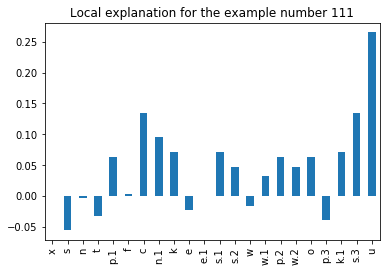

In [66]:
import awswrangler as wr

local_explanations_out = wr.s3.read_csv(explainability_output_path + '/explanations_shap/out.csv')
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature values -- Label", train.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=90
)